### Import Requirements

In [1]:
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

### Pose Estimation Model and Transformation Functions

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def estimate_pose(image):
    # Setup mediapipe instance
    pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # Recolor image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Make detection
    results = pose.process(image)

    # # Recolor back to BGR
    # image.flags.writeable = True
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # # Render detections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    #                             mp_drawing.DrawingSpec(
    #                                 color=(245, 117, 66), thickness=2, circle_radius=2),
    #                             mp_drawing.DrawingSpec(
    #                                 color=(245, 66, 230), thickness=2, circle_radius=2)
    #                             )
    # # Return output
    # cv2.imwrite('output.png', image)
    try:
        return results.pose_landmarks.landmark
    except AttributeError:
        return None


def calculate_angle(first, mid, end):
    first = np.array(first) 
    mid = np.array(mid)  # Mid
    end = np.array(end)  # End

    radians = np.arctan2(end[1]-mid[1], end[0]-mid[0]) - \
        np.arctan2(first[1]-mid[1], first[0]-mid[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

def calculate_all_angles(landmarks):
    angle_map = {
        'SHOULDER': ['ELBOW', 'SHOULDER', 'HIP'],
        'ELBOW': ['SHOULDER', 'ELBOW', 'WRIST'],
        'HIP': ['KNEE', 'HIP', 'SHOULDER'],
        'KNEE': ['HIP', 'KNEE', 'ANKLE'],
        'ANKLE': ['KNEE', 'ANKLE', 'PINKY']
    }
    
    angles = {}
    for angle_name, landmark_points in angle_map.items():
        for side in ['LEFT', 'RIGHT']:
            # get landmark names
            landmark_names = []
            for point in landmark_points:
                landmark_names.append(side+'_'+point)
            # calculate angle
            first = [landmarks[getattr(mp_pose.PoseLandmark, landmark_names[0]).value].x,
                     landmarks[getattr(mp_pose.PoseLandmark, landmark_names[0]).value].y]
            mid = [landmarks[getattr(mp_pose.PoseLandmark, landmark_names[1]).value].x,
                   landmarks[getattr(mp_pose.PoseLandmark, landmark_names[1]).value].y]
            end = [landmarks[getattr(mp_pose.PoseLandmark, landmark_names[2]).value].x,
                   landmarks[getattr(mp_pose.PoseLandmark, landmark_names[2]).value].y]
            angle = calculate_angle(first, mid, end)
            angles[side+'_'+angle_name] = [angle]

            # cv2.putText(image, str(angle),
            #             tuple(np.multiply(mid, [640, 480]).astype(int)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
            #             )
            # cv2.imwrite('output.png', image)
    angles = pd.DataFrame(angles)
    return angles

def process_folder(folder_path):
    data = pd.DataFrame()
    # for each image in the folder
    for img_path in glob(folder_path+'/*.jpg'):
        # read image
        image = cv2.imread(img_path)
        # estimate pose landmarks
        landmarks = estimate_pose(image)
        if landmarks:
            # calculate all angles
            angles = calculate_all_angles(landmarks)
            # append to data
            data = pd.concat([data, angles])
    return data

### Feature Extraction Job for Activity Detection


In [ ]:
# sitting = process_folder('activity-detection-data/sitting')
# sitting['label'] = 0
# sitting.to_excel('./sitting.xlsx', index='False', engine='openpyxl')

In [ ]:
# standing = process_folder('activity-detection-data/standing')
# standing['label'] = 1
# standing.to_excel('./standing.xlsx', index='False', engine='openpyxl')

### Data Preperation

In [ ]:
sitting = pd.read_excel('sitting.xlsx', engine='openpyxl').drop(columns='Unnamed: 0')
standing = pd.read_excel('standing.xlsx', engine='openpyxl').drop(columns='Unnamed: 0')
df_model = pd.concat([sitting, standing])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(columns='label'), df_model['label'], test_size=0.2, random_state=42)

### Try the first model

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,5.0,8.0,1.0,13.0,13.0


### Model Selection

In [ ]:
pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("classifier", LGBMClassifier())])

params = [
    {
      'scaler': [StandardScaler(), MinMaxScaler()],
      'classifier': [LogisticRegression()],
      "classifier__C": [0.1, 1.0, 10.0, 100.0],
    },
    {
      'scaler': [StandardScaler(), MinMaxScaler()],
      'classifier': [RandomForestClassifier()],
      'classifier__max_depth': np.arange(1, 22, 2),
      'classifier__n_estimators': np.arange(10, 500, 50),
    },
    {
      'scaler': [StandardScaler(), MinMaxScaler()],
      'classifier': [LGBMClassifier()],
      'classifier__max_depth': np.arange(1, 22, 2),
      'classifier__num_leaves': np.arange(2, 103, 5),
      'classifier__n_estimators': np.arange(10, 311, 50),
      'classifier__learning_rate': np.arange(0.01, 1.502, 0.05)
    },
]

search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=5, random_state=42)
search.fit(X_train, y_train)

# search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=10, random_state=42)
# search.fit(X_train, y_train)

print('Best Estimator:', search.best_estimator_)
print('Best Score:', search.best_score_)

Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.21000000000000002, max_depth=17,
                                n_estimators=310, num_leaves=67))])
Best Score: 0.5222222222222221


In [ ]:
results = pd.DataFrame(search.cv_results_)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


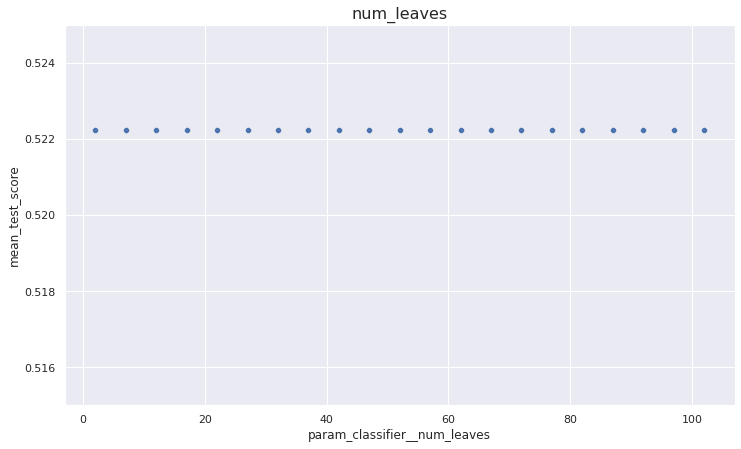

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


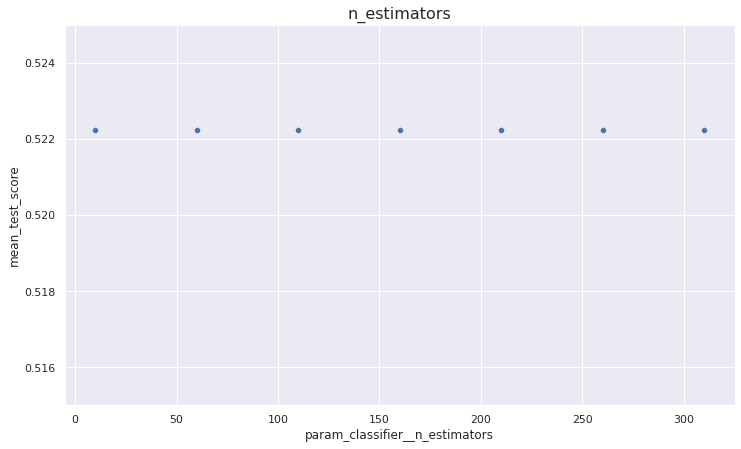

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


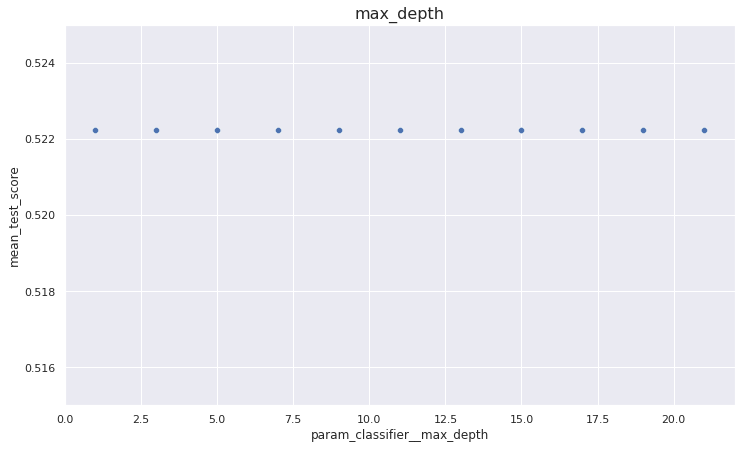

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


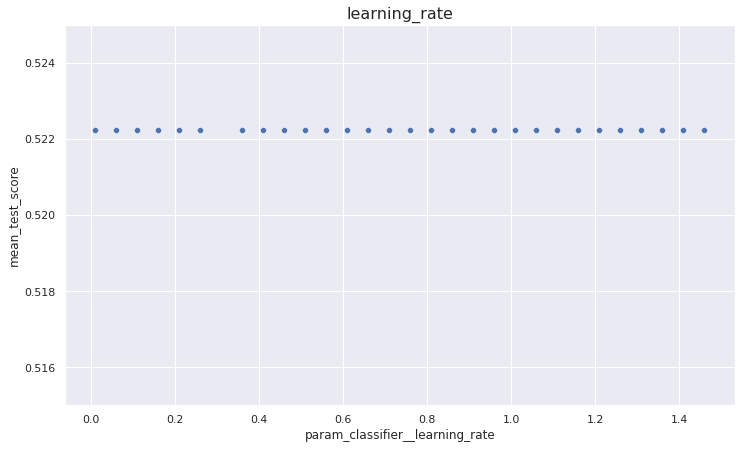

In [ ]:
results_ = results.loc[results['param_classifier'].apply(lambda x: type(x)==LGBMClassifier)]
for col in results_.columns:
  if 'param_classifier__' in col:
    sns.set( rc = {'figure.figsize' : ( 12, 7 ), 
                  'axes.labelsize' : 12 })
    plt.title(col.split('__')[1], size = 16)
    g = sns.scatterplot(results_[col], results_['mean_test_score'])
    g.set(ylim=(0.515, 0.525))
    plt.show()

In [ ]:
pd.DataFrame(classification_report(y_test, y_pred>0.5, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,5.0,8.0,1.0,13.0,13.0


### Visualization of Activity Detection

In [ ]:
model_pipe = search.best_estimator_

In [ ]:
def draw_landmarks(img, landmarks):
    mp_drawing.draw_landmarks(image, landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(
                                color=(245, 117, 66), thickness=2, circle_radius=2),
                            mp_drawing.DrawingSpec(
                                color=(245, 66, 230), thickness=2, circle_radius=2)
                            )

def draw_text(img, text):   
    font = cv2.FONT_HERSHEY_PLAIN
    pos = (25, 25)
    font_scale = 5
    font_thickness = 2
    text_color = (0, 255, 0)
    text_color_bg = (0, 0, 0)

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, (x,y-10), (x + text_w, y + text_h + 20), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1),
                font, font_scale, text_color, font_thickness)

    return text_size


In [ ]:
# Read image
image = cv2.imread('example.jpg')

# Setup mediapipe instance
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Recolor image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.flags.writeable = False

# Make detection
results = pose.process(image)

# Recolor back to BGR
image.flags.writeable = True
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Draw landmarks
draw_landmarks(image, results.pose_landmarks)

# Write pose image
cv2.imwrite('example-pose.jpg', image)

X = calculate_all_angles(results.pose_landmarks.landmark)
y = model_pipe.predict(X)
activity = None
if y == 0:
    activity = 'Sitting'
else:
    activity = 'Standing'
# Write the label
draw_text(image, 'Sitting')

# Write pose image
cv2.imwrite('example-activity.jpg', image)

### For Later

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Initialize the model
model = keras.Sequential()
# Add layers
# model.add(layers.Dense(1, activation='softmax', input_dim=10))
model.add(layers.Dense(5, activation='relu', input_dim=10))
# model.add(layers.Dense(3, activation='softmax'))
model.add(layers.Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Fit the model
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5208


In [ ]:
pd.DataFrame(classification_report(y_test, y_pred>0.5, output_dict=True))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.0,0.615385,0.615385,0.307692,0.378698
recall,0.0,1.000000,0.615385,0.500000,0.615385
f1-score,0.0,0.761905,0.615385,0.380952,0.468864
support,5.0,8.000000,0.615385,13.000000,13.000000
